
#  TMDb Movie Data Analysis

This notebook analyzes movie data fetched from the TMDb API. It follows a full data pipeline approach:
- Fetching data via API
- Cleaning and preprocessing
- Extracting key fields
- Performing KPI analysis
- Visualizing insights

---
## Step 1: Import Libraries & Load API Key


##  Fetch Data from TMDb API

In [1]:
import pandas as pd
import requests
import os
from dotenv import load_dotenv
from typing import List

# ===============================
#  Load API Key from .env File
# ===============================
load_dotenv()  # Looks for .env in same directory
api_key = os.getenv("API_KEY")


# ==================================================
#  Function: Fetch movie data by TMDB movie IDs
# ==================================================
def fetch_movie_data(movie_ids: List[int], api_key: str) -> pd.DataFrame:
    """
    Fetches movie details from TMDB API for a list of movie IDs.
    
    Parameters:
        movie_ids (List[int]): A list of TMDB movie IDs.
        api_key (str): My TMDB API key.
        
    Returns:
        pd.DataFrame: A DataFrame of movie data.
    """
    base_url = "https://api.themoviedb.org/3/movie/{}"
    params = {
        "api_key": api_key,
        "append_to_response": "credits"
    }

    all_data = []

    for movie_id in movie_ids:
        try:
            response = requests.get(base_url.format(movie_id), params=params)
            
            # Handle invalid or missing movies
            if response.status_code == 200:
                all_data.append(response.json())
            else:
                print(f" Movie ID {movie_id} not found. Status: {response.status_code}")
        
        except requests.exceptions.RequestException as e:
            print(f" Network error while fetching Movie ID {movie_id}: {e}")

     #  Save fetched data to cache
    #with open(cache_file, 'w', encoding='utf-8') as f:
        #json.dump(all_data, f, indent=2)
    
    # Return as DataFrame
    return pd.DataFrame(all_data)


movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397,
    420818, 24428, 168259, 99861, 284054, 12445,
    181808, 330457, 351286, 109445, 321612, 260513
]

# Call fetch function
df_movies = fetch_movie_data(movie_ids, api_key)

# Preview first few rows
df_movies.head()

 Movie ID 0 not found. Status: 404


,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits
0,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,[US],en,...,2799439100,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,False,8.237,26245,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995,tt0499549,[US],en,...,2923706026,162,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Enter the world of Pandora.,Avatar,False,7.588,32158,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
2,False,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,[US],en,...,2068223624,136,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.261,19689,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
3,False,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/avengers-infinit...,299536,tt4154756,[US],en,...,2052415039,149,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Destiny arrives all the same.,Avengers: Infinity War,False,8.235,30429,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
4,False,/sCzcYW9h55WcesOqA12cgEr9Exw.jpg,None,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.paramountmovies.com/movies/titanic,597,tt0120338,[US],en,...,2264162353,194,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Nothing on Earth could come between them.,Titanic,False,7.900,25907,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


##  Step 2: Clean and Preprocess Movie Data

In [2]:
import pandas as pd
import numpy as np

df = df_movies

def clean_basic_movie_data(df):
    """
    Cleans TMDB movie data by:
    - Dropping irrelevant columns
    - Flattening JSON-like fields (genres, countries, languages, etc.)
    - Handling missing/unrealistic values
    - Converting data types
    - Filtering only 'Released' movies
    - Reordering columns for final dataset

    Parameters:
        df (pd.DataFrame): Raw TMDB movie DataFrame

    Returns:
        pd.DataFrame: Cleaned and structured DataFrame
    """

    # --------------------------------------
    # 1. Drop irrelevant columns
    # --------------------------------------
    to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
    df.drop(columns=to_drop, inplace=True, errors='ignore')

    # --------------------------------------
    # 2. Clean JSON-like columns (overwrite)
    # --------------------------------------
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(
        lambda x: x['name'] if isinstance(x, dict) else np.nan
    )

    df['genres'] = df['genres'].apply(
        lambda x: "|".join([g['name'] for g in x]) if isinstance(x, list) else np.nan
    )

    df['production_countries'] = df['production_countries'].apply(
        lambda x: "|".join([c['name'] for c in x]) if isinstance(x, list) else np.nan
    )

    df['spoken_languages'] = df['spoken_languages'].apply(
        lambda x: "|".join([l['english_name'] for l in x]) if isinstance(x, list) else np.nan
    )

    df['production_companies'] = df['production_companies'].apply(
        lambda x: "|".join([p['name'] for p in x]) if isinstance(x, list) else np.nan
    )

    # --------------------------------------
    # 3. Convert data types (handle errors)
    # --------------------------------------
    df['id'] = pd.to_numeric(df['id'], errors='coerce')
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # --------------------------------------
    # 4. Replace unrealistic values
    # --------------------------------------
    df[['budget', 'revenue', 'runtime']] = df[['budget', 'revenue', 'runtime']].replace(0, np.nan)

    # Convert budget and revenue to millions
    df['budget'] = df['budget'] / 1_000_000
    df['revenue'] = df['revenue'] / 1_000_000

    # Fix vote_count = 0 with high vote_average (likely invalid)
    df.loc[(df['vote_count'] == 0) & (df['vote_average'] > 0), 'vote_average'] = np.nan

    # Clean placeholders in text
    for col in ['overview', 'tagline']:
        df[col] = df[col].replace(['No Data', 'null', '', 'None'], np.nan)

    # --------------------------------------
    # 5. Remove bad rows
    # --------------------------------------
    df = df.drop_duplicates(subset='id')
    df = df.dropna(subset=['id', 'title'])
    df = df[df.notna().sum(axis=1) >= 10]
    df = df[df['status'] == 'Released']
    df.drop(columns='status', inplace=True, errors='ignore')

    

    return df

df.head(2)
df.columns


Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'origin_country', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

In [4]:
df.head(2)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits
0,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,[US],en,...,2799439100,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,False,8.237,26242,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995,tt0499549,[US],en,...,2923706026,162,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Enter the world of Pandora.,Avatar,False,7.588,32154,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


In [3]:
df_cleaned = clean_basic_movie_data(df_movies)
df_cleaned.head(2)

,backdrop_path,belongs_to_collection,budget,genres,id,origin_country,original_language,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,credits
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,The Avengers Collection,356.0,Adventure|Science Fiction|Action,299534,[US],en,After the devastating events of Avengers: Infi...,31.4799,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,...,United States of America,2019-04-24,2799.439100,181,English|Japanese|Xhosa,Avenge the fallen.,Avengers: Endgame,8.237,26245,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,Avatar Collection,237.0,Action|Adventure|Fantasy|Science Fiction,19995,[US],en,"In the 22nd century, a paraplegic Marine is di...",31.6851,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,...,United States of America|United Kingdom,2009-12-15,2923.706026,162,English|Spanish,Enter the world of Pandora.,Avatar,7.588,32158,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


ANOMALIES DETECTED

During data inspection, the genres column was found to contain multiple genres combined with a pipe (|) separator.

 Many unique combinations exist that differ only in order, such as Action|Adventure|Science Fiction vs. Adventure|Science Fiction|Action. These represent the same genres but are treated as separate values, which can lead to inconsistency in analysis and visualization.
 Similarly, the production_countries column shows combinations like United States of America|United Kingdom and its reversed version

##  Extract Cast, Crew, and Director Info

In [4]:
import json

def extract_credits_fields(df):
    """
    Extracts structured fields from the 'credits' JSON-like column:
    - First 3 cast names
    - Cast size
    - Crew size
    - Director name

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'credits' column as stringified JSON

    Returns:
        pd.DataFrame: Updated DataFrame with new fields and 'credits' removed
    """

    # Helper function to safely parse credits
    def parse_credits(x):
        try:
            return json.loads(x) if isinstance(x, str) else x
        except Exception:
            return {}

    # Parse 'credits' JSON string into dict
    df['credits_parsed'] = df['credits'].apply(parse_credits)

    # Extract cast names
    def get_main_cast(credit_obj):
        try:
            cast = credit_obj.get('cast', [])
            return ", ".join([actor['name'] for actor in cast[:3]])  # top 3
        except:
            return np.nan

    # Get cast and crew size
    def get_cast_size(credit_obj):
        return len(credit_obj.get('cast', [])) if isinstance(credit_obj, dict) else np.nan

    def get_crew_size(credit_obj):
        return len(credit_obj.get('crew', [])) if isinstance(credit_obj, dict) else np.nan

    # Extract director name
    def get_director(credit_obj):
        if isinstance(credit_obj, dict):
            for person in credit_obj.get('crew', []):
                if person.get('job') == 'Director':
                    return person.get('name')
        return np.nan

    # Create new columns
    df['main_cast'] = df['credits_parsed'].apply(get_main_cast)
    df['cast_size'] = df['credits_parsed'].apply(get_cast_size)
    df['crew_size'] = df['credits_parsed'].apply(get_crew_size)
    df['director'] = df['credits_parsed'].apply(get_director)

    # Drop original credits and parsed credits columns
    df.drop(columns=['credits', 'credits_parsed'], inplace=True, errors='ignore')

    return df


In [5]:
#from movie_analysis import extract_credits_fields

df_cleaned = extract_credits_fields(df_cleaned)
df_cleaned.head(2)


,backdrop_path,belongs_to_collection,budget,genres,id,origin_country,original_language,overview,popularity,poster_path,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,main_cast,cast_size,crew_size,director
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,The Avengers Collection,356.0,Adventure|Science Fiction|Action,299534,[US],en,After the devastating events of Avengers: Infi...,31.4799,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,...,181,English|Japanese|Xhosa,Avenge the fallen.,Avengers: Endgame,8.237,26245,"Robert Downey Jr., Chris Evans, Mark Ruffalo",105,593,Anthony Russo
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,Avatar Collection,237.0,Action|Adventure|Fantasy|Science Fiction,19995,[US],en,"In the 22nd century, a paraplegic Marine is di...",31.6851,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,...,162,English|Spanish,Enter the world of Pandora.,Avatar,7.588,32158,"Sam Worthington, Zoe Saldaña, Sigourney Weaver",65,986,James Cameron


In [9]:
df_cleaned.columns

Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'tagline',
       'title', 'vote_average', 'vote_count', 'main_cast', 'cast_size',
       'crew_size', 'director'],
      dtype='object')

## 📊 Step 3: KPI Analysis – Ranking Movies by Key Metrics

In [9]:
# kpi_analysis.py

import pandas as pd

# ===============================================
# KPI Analysis Functions for TMDb Movie Dataset
# ===============================================

def rank_movies(df):
    """
    Ranks movies based on various performance metrics.
    Includes filters for ROI (budget ≥ 10M) and rating (votes ≥ 10).
    Returns a dictionary of top-ranked DataFrames.
    """
    df = df.copy()
    df['profit'] = df['revenue'] - df['budget']
    df['roi'] = df['revenue'] / df['budget']

    roi_df = df[df['budget'] >= 10]
    rated_df = df[df['vote_count'] >= 10]

    def top_n(data, column, ascending=False, n=10):
        return data.sort_values(by=column, ascending=ascending).head(n)

    results = {
        'highest_revenue': top_n(df, 'revenue'),
        'highest_budget': top_n(df, 'budget'),
        'highest_profit': top_n(df, 'profit'),
        'lowest_profit': top_n(df, 'profit', ascending=True),
        'highest_roi': top_n(roi_df, 'roi'),
        'lowest_roi': top_n(roi_df, 'roi', ascending=True),
        'most_voted': top_n(df, 'vote_count'),
        'highest_rated': top_n(rated_df, 'vote_average'),
        'lowest_rated': top_n(rated_df, 'vote_average', ascending=True),
        'most_popular': top_n(df, 'popularity')
    }

    return results


def compare_franchises(df):
    """
    Compares franchise vs. standalone movies across key metrics:
    Mean revenue, median ROI, mean budget, popularity, and rating.
    """
    df = df.copy()
    df['is_franchise'] = df['belongs_to_collection'].notnull()
    df['roi'] = df['revenue'] / df['budget']

    grouped = df.groupby('is_franchise').agg({
        'revenue': 'mean',
        'roi': 'median',
        'budget': 'mean',
        'popularity': 'mean',
        'vote_average': 'mean'
    }).rename(index={True: 'Franchise', False: 'Standalone'})

    return grouped


def successful_franchises(df):
    """
    Returns top 10 most successful franchises based on:
    Total movies, budget, revenue, and mean rating.
    """
    df = df[df['belongs_to_collection'].notnull()].copy()
    df['collection_name'] = df['belongs_to_collection'].apply(
        lambda x: x.get('name') if isinstance(x, dict) else None
    )

    grouped = df.groupby('collection_name').agg(
        total_movies=('id', 'count'),
        total_budget=('budget', 'sum'),
        mean_budget=('budget', 'mean'),
        total_revenue=('revenue', 'sum'),
        mean_revenue=('revenue', 'mean'),
        mean_rating=('vote_average', 'mean')
    ).sort_values(by='total_revenue', ascending=False)

    return grouped.head(10)


def successful_directors(df):
    """
    Returns top 10 most successful directors based on:
    Movie count, total revenue, and average rating.
    """
    grouped = df.groupby('director').agg(
        total_movies=('id', 'count'),
        total_revenue=('revenue', 'sum'),
        mean_rating=('vote_average', 'mean')
    ).sort_values(by='total_revenue', ascending=False)

    return grouped.head(10)


In [ ]:
ranked = rank_movies(df)
display(ranked['highest_revenue'])


In [21]:
print("\n Franchise vs Standalone Performance")
display(compare_franchises(df).style.format({
    'revenue': "{:.2f} M",
    'roi': "{:.2f}",
    'budget': "{:.2f} M",
    'popularity': "{:.1f}",
    'vote_average': "{:.1f}"
}))



 Franchise vs Standalone Performance


,revenue,roi,budget,popularity,vote_average
is_franchise,,,,,
Standalone,1765.14 M,9.62,180.00 M,41.9,7.4
Franchise,1682.64 M,7.79,219.88 M,27.3,7.4


## 📈 Step 4: Visualizations of Movie Trends & Performance

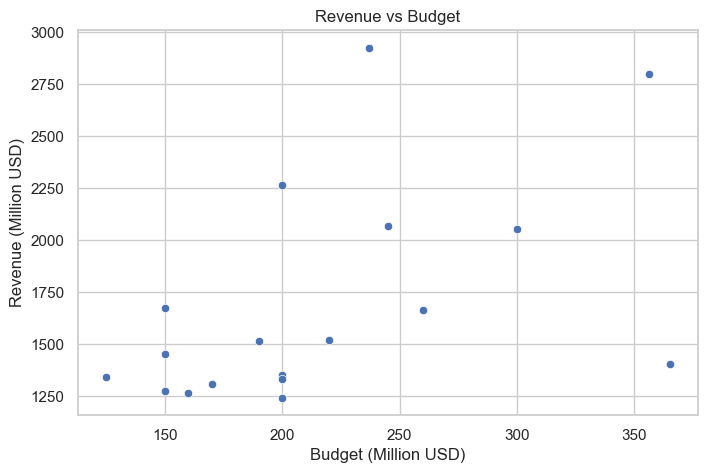

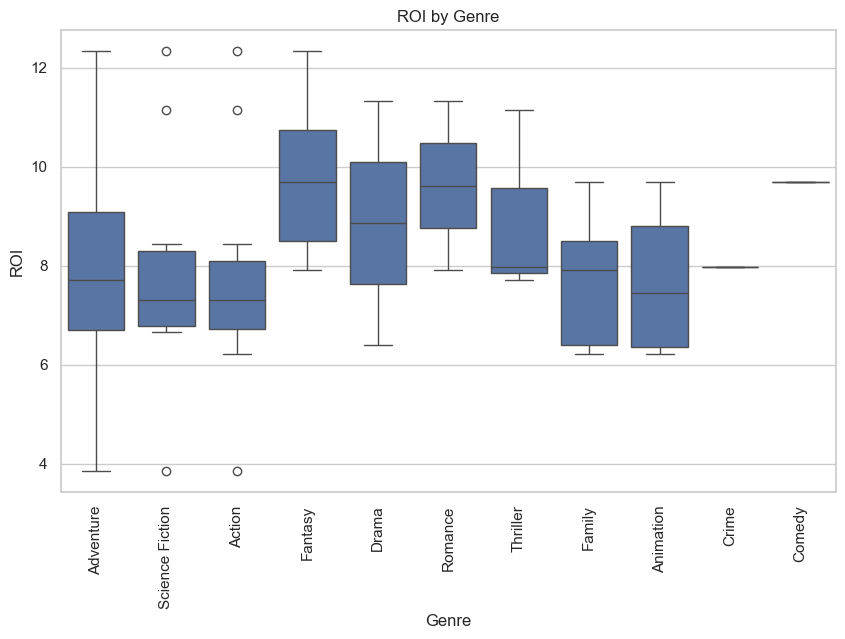

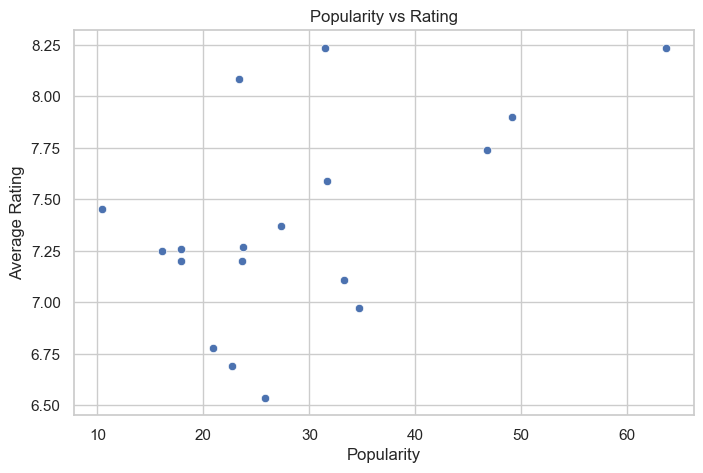

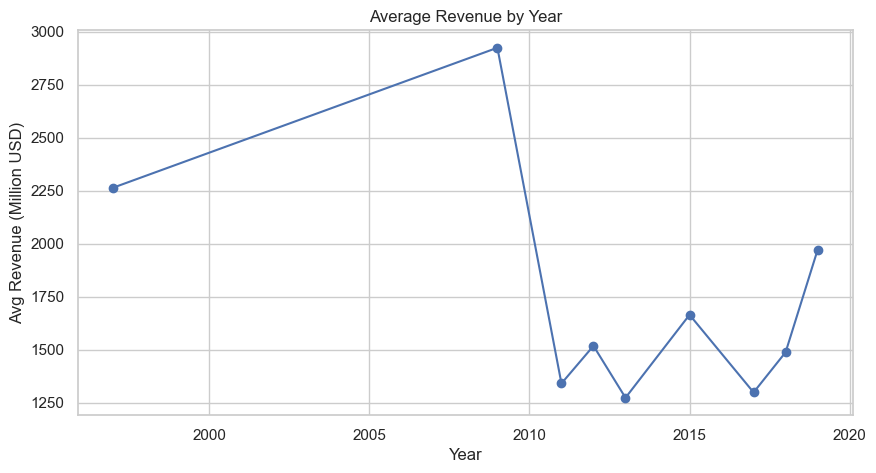

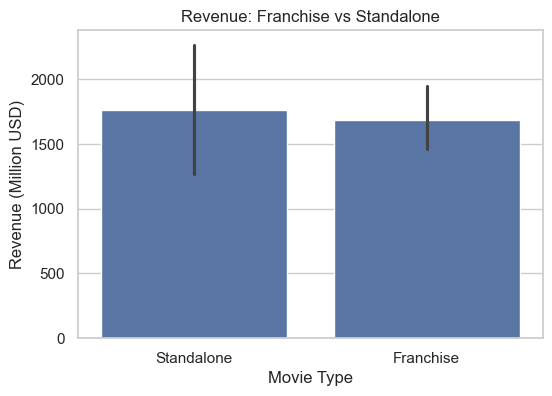

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_visualizations(df):
    """
    Generates individual plots for:
    - Revenue vs Budget
    - ROI by Genre
    - Popularity vs Rating
    - Yearly Revenue Trends
    - Franchise vs Standalone Comparison
    """

    # Prepare working copy
    df = df.copy()
    df['roi'] = df['revenue'] / df['budget']
    df['year'] = df['release_date'].dt.year
    df['is_franchise'] = df['belongs_to_collection'].notna()

    sns.set(style="whitegrid")

    # 1. Revenue vs Budget
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='budget', y='revenue')
    plt.title("Revenue vs Budget")
    plt.xlabel("Budget (Million USD)")
    plt.ylabel("Revenue (Million USD)")
    plt.show()

    # 2. ROI Distribution by Genre
    genre_df = df.dropna(subset=['genres']).copy()
    genre_df = genre_df.assign(genre_split=genre_df['genres'].str.split('|')).explode('genre_split')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=genre_df, x='genre_split', y='roi')
    plt.xticks(rotation=90)
    plt.title("ROI by Genre")
    plt.xlabel("Genre")
    plt.ylabel("ROI")
    plt.show()

    # 3. Popularity vs Rating
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='popularity', y='vote_average')
    plt.title("Popularity vs Rating")
    plt.xlabel("Popularity")
    plt.ylabel("Average Rating")
    plt.show()

    # 4. Yearly Revenue Trend
    yearly = df.groupby('year')['revenue'].mean().dropna()
    plt.figure(figsize=(10, 5))
    yearly.plot(marker='o')
    plt.title("Average Revenue by Year")
    plt.xlabel("Year")
    plt.ylabel("Avg Revenue (Million USD)")
    plt.grid(True)
    plt.show()

    # 5. Franchise vs Standalone Revenue Comparison
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x='is_franchise', y='revenue')
    plt.xticks([0, 1], ['Standalone', 'Franchise'])
    plt.title("Revenue: Franchise vs Standalone")
    plt.ylabel("Revenue (Million USD)")
    plt.xlabel("Movie Type")
    plt.show()

#from movie_analysis import generate_visualizations

generate_visualizations(df_cleaned)
